# Further Experiments

Note: This notebook contains further experiments that were not pursued further.

In this Code a model consisting of two separate GNNs is used to predict mu and sigma individually.

In [64]:
import sys
import torch.cuda
import yaml
from torch_geometric.loader import DataLoader
import os
from models import *
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import cmasher as cmr

sys.path.append('../utils')
from helpers import *

# Load Data

In [2]:
with open('experiments/large/best_GlobalInfo/config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)
# Load Data
# Get Data from feather
data = load_data(indexed=False)

if not os.path.exists("dist_matrix.npy"):
    stations = load_stations(data)  # This needs to be done here because we need all stations
    dist_matrix = compute_dist_matrix(stations)
    np.save('dist_matrix.npy', dist_matrix)

# Create correlation matrix for further graph generating methods
if not os.path.exists("corr_matrix.npy"):
    # Creation of new Graph using Correlation of observations
    data_cut = data.iloc[:-1460]
    time_series = data_cut.pivot(index='date', columns='station', values='obs')
    time_series = time_series.interpolate()
    corr_matrix = time_series.corr().clip(lower=0)
    corr_matrix = 1 - corr_matrix
    corr_matrix = np.nan_to_num(corr_matrix, nan=1)
    np.save('corr_matrix.npy', corr_matrix)

# Clean Data
data = clean_data(data, max_missing=121, max_alt=1000.0)

# Normalize Data
normalized_data = normalize_data(data, last_obs=-len(data[data.date.dt.year == 2016]), method="max")

# Get List of stations with all stations -> will break further code if cut already
stations = load_stations(data)

# Create Dataset
if config['data']['use_corr']:
    dist_matrix = np.load('corr_matrix.npy')
else:
    dist_matrix = np.load('dist_matrix.npy')
position_matrix = np.array(stations[['station', 'lon', 'lat']])

torch_data = []
dates = tqdm(data['date'].unique()[:-367])  # last 366 days are used for testing
for date in dates:
    dates.set_postfix({"date": date})
    torch_data.append(create_data(df=normalized_data,
                                  date=date,
                                  dist_matrix=dist_matrix,
                                  position_matrix=position_matrix,
                                  method=config['data']['method'],
                                  max_dist=config['data']['max_dist'],
                                  k=config['data']['nearest_k'],
                                  nearest_k_mode=config['data']['nearest_k_mode']))

# Set device
device = torch.device(f"cuda:1" if torch.cuda.is_available() else "cpu")
torch_data_train = [tensor.to(device) for tensor in torch_data]
train_loader = DataLoader(torch_data_train, batch_size=config['model']['batch_size'], shuffle=True)

100%|██████████| 3163/3163 [00:49<00:00, 64.43it/s, date=2015-12-30 00:00:00+00:00]
/home/feik/.conda/envs/GNN2/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [15]:
# Create Model
class MuEstimator(GNNGI):
    def __init__(self, in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels, num_layers, embedding_dim):
        super(MuEstimator, self).__init__(in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels, num_layers, embedding_dim)
        self.lin = Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch_id, global_feature=None):
        x = self.emb(x)  # embed station id

        if global_feature is None:
            global_feature = self.pool(x, batch=batch_id)  # Do batch-wise pooling to create initial global feature

        x, global_feature = self.convolutions[0](x, edge_index, edge_attr, global_feature, batch_id)
        x = self.relu(x)
        global_feature = self.relu(global_feature)

        if len(self.convolutions) > 1:
            for conv in self.convolutions[1:]:
                x_new, global_features_new = conv(x, edge_index, edge_attr, global_feature, batch_id)
                x = x + self.relu(x_new)  # Resnet
                global_feature = global_feature + self.relu(global_features_new)  #Resnet

        x = self.lin(x)
        return x


class SigmaEstimator(GNNGI):
    def __init__(self, in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels, num_layers, embedding_dim):
        super(SigmaEstimator, self).__init__(in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels, num_layers, embedding_dim)
        self.lin = Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch_id, global_feature=None):
        x = self.emb(x)  # embed station id

        if global_feature is None:
            global_feature = self.pool(x, batch=batch_id)  # Do batch-wise pooling to create initial global feature

        x, global_feature = self.convolutions[0](x, edge_index, edge_attr, global_feature, batch_id)
        x = self.relu(x)
        global_feature = self.relu(global_feature)

        if len(self.convolutions) > 1:
            for conv in self.convolutions[1:]:
                x_new, global_features_new = conv(x, edge_index, edge_attr, global_feature, batch_id)
                x = x + self.relu(x_new)  # Resnet
                global_feature = global_feature + self.relu(global_features_new)  #Resnet

        x = self.lin(x)
        x = F.softplus(x)
        return x


class SplitModel(torch.nn.Module):
    def __init__(self, in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels, num_layers, embedding_dim):
        """
        Create an instance of a Graph Neural Network with global Information sharing
        :param in_channels: dimension of node attributes before embedding
        :param edge_channels: dimension of edge attributes
        :param global_channels: dimension of global information vector, should be the same as in_channels+edge_channels
        :param hidden_channels: dimension of the message passed along the edges
        :param out_channels: dimension of the new node features
        :param global_out_channels: dimension of the new global feature
        :param num_layers: number of layers
        :param embedding_dim: dimension to use of node embedding
        """
        super(SplitModel, self).__init__()
        self.mu_estimator = MuEstimator(in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels, num_layers, embedding_dim)
        self.sigma_estimator = SigmaEstimator(in_channels, edge_channels, global_channels, hidden_channels, out_channels, global_out_channels, num_layers, embedding_dim)

    def forward(self, x, edge_index, edge_attr, batch_id, global_feature=None):
        x_mu = self.mu_estimator(x, edge_index, edge_attr, batch_id, global_feature)
        x_sigma = self.sigma_estimator(x, edge_index, edge_attr, batch_id, global_feature)
        mu_sigma = torch.cat([x_mu, x_sigma], dim=1)
        return mu_sigma


In [16]:
num_features = torch_data[0].num_features
emb_num_features = num_features + config['model']['embed_dim'] - 1
model = SplitModel(in_channels=emb_num_features,
                    edge_channels=1,
                    global_channels=emb_num_features,
                    hidden_channels=config['model']['hidden_channels'],
                    out_channels=config['model']['hidden_channels'],
                    global_out_channels=emb_num_features,
                    num_layers=config['model']['num_layers'],
                    embedding_dim=config['model']['embed_dim'])
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['model']['lr'])

In [17]:
# Train Loop
train_losses = []
pbar = trange(config['training']['n_epochs'])
for epoch in pbar:
    # Train for one epoch
    model.train()
    loss=0.0
    train_loss = 0.0
    # Train loop
    for batch in train_loader:
        #batch.to(device)  # can be removed if data fits into gpu memory
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch_id=batch.batch)
        loss = crps(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    pbar.set_postfix({"Train_Loss": train_loss})

    if torch.isnan(loss).any():
        print("Loss is NaN. Training terminated.")
        sys.exit(1)

100%|██████████| 82/82 [14:08<00:00, 10.35s/it, Train_Loss=0.795]


# Test

In [19]:
torch_data_test = []
dates = tqdm(data['date'].unique()[-367:])  # last 366 days are used for testing
for date in dates:
    dates.set_postfix({"date": date})
    torch_data_test.append(create_data(df=normalized_data,
                                  date=date,
                                  dist_matrix=dist_matrix,
                                  position_matrix=position_matrix,
                                  method=config['data']['method'],
                                  max_dist=config['data']['max_dist'],
                                  k=config['data']['nearest_k'],
                                  nearest_k_mode=config['data']['nearest_k_mode']))

torch_data_test = [tensor.to(device) for tensor in torch_data_test]
test_loader = DataLoader(torch_data_test, batch_size=config['model']['batch_size'], shuffle=False)

100%|██████████| 367/367 [00:05<00:00, 62.69it/s, date=2016-12-31 00:00:00+00:00]


In [24]:
out_list = []
sigma_list_batch = []
y_list = []
for batch in test_loader:
    out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
    out_list.append(out)
    y = batch.y
    y_list.append(y)
out = torch.vstack(out_list)
y = torch.concat(y_list)
err = crps(mu_sigma=out, y=y)
print(err)

OutOfMemoryError: CUDA out of memory. Tried to allocate 46.00 MiB (GPU 1; 23.68 GiB total capacity; 22.06 GiB already allocated; 26.31 MiB free; 22.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [43]:
mu, sigma = torch.split(out, 1, dim=-1)
mu = mu.detach().cpu().numpy()
sigma = sigma.detach().cpu().numpy()
y = y.cpu().numpy()

# Plots

Text(0.5, 1.0, 'Predicted vs. Observed 2-m Temperatures\nCRPS=0.8700')

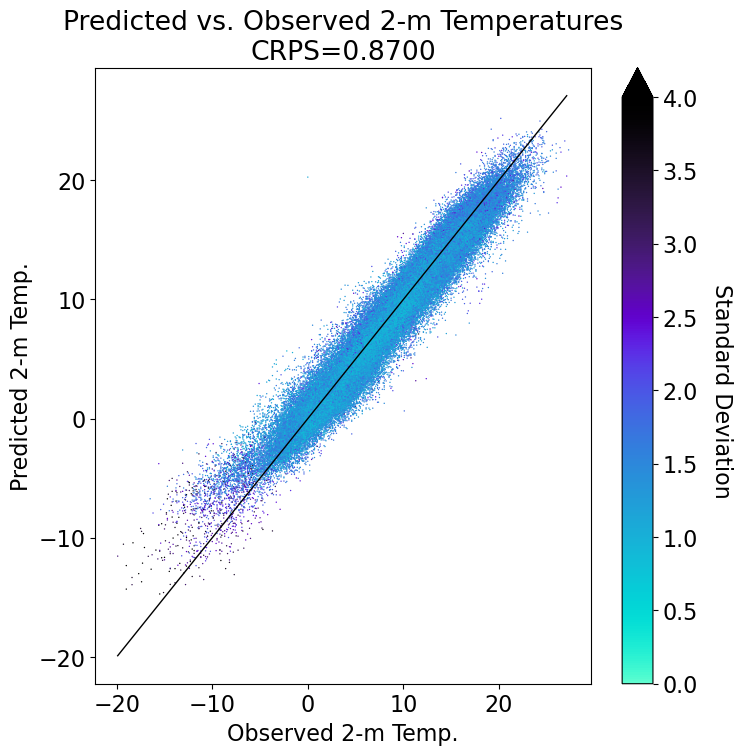

In [51]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")  # line
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap=cmr.get_sub_cmap(cmr.cosmic_r,0.0,1), vmin=0, vmax=4, rasterized=True)

cbar = plt.colorbar(extend='max')
cbar.set_label('Standard Deviation', rotation=270, labelpad=25)
plt.xlabel('Observed 2-m Temp.')
plt.ylabel('Predicted 2-m Temp.')
plt.title(f"Predicted vs. Observed 2-m Temperatures\nCRPS={err:.4f}")

# Explainablility

In [52]:
from torch_geometric.explain import Explainer, ModelConfig, ThresholdConfig
from torch_geometric.explain import GNNExplainer

## $\mu$-Explainer

In [66]:
tmp = torch_data_test[-1]
node_index = [1,2,3]

In [67]:
mu_explainer = Explainer(model=model.mu_estimator,
                algorithm=GNNExplainer(),
                explanation_type='model',
                node_mask_type='attributes',
                edge_mask_type='object',
                model_config=ModelConfig(
                    mode='regression',
                    task_level='node',
                    return_type='raw')
                )
sigma_explainer = Explainer(model=model.sigma_estimator,
                algorithm=GNNExplainer(),
                explanation_type='model',
                node_mask_type='attributes',
                edge_mask_type='object',
                model_config=ModelConfig(
                    mode='regression',
                    task_level='node',
                    return_type='raw')
                )

mu_explanation = mu_explainer(tmp.x.to(device),
                        tmp.edge_index.to(device),
                        edge_attr=tmp.edge_attr.to(device),
                        batch_id=torch.zeros(tmp.x.shape[0], dtype=torch.int64 ,device=device),
                        index=node_index)

sigma_explanation = mu_explainer(tmp.x.to(device),
                        tmp.edge_index.to(device),
                        edge_attr=tmp.edge_attr.to(device),
                        batch_id=torch.zeros(tmp.x.shape[0], dtype=torch.int64 ,device=device),
                        index=node_index)

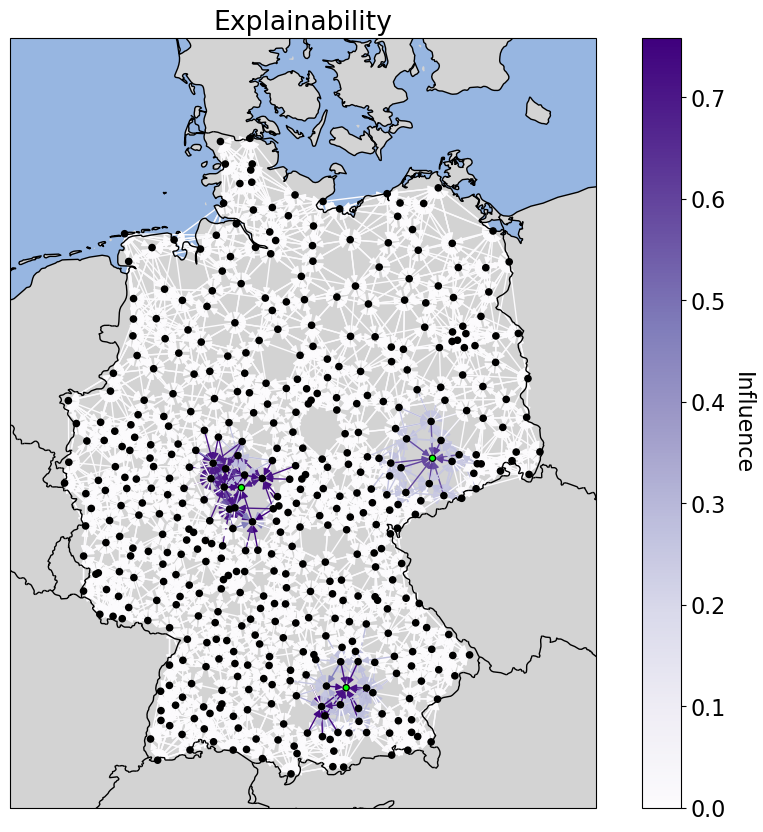

In [68]:
helpers.visualize_explanation(subgraph=mu_explanation,
                              fullgraph=tmp,
                              stations=stations)

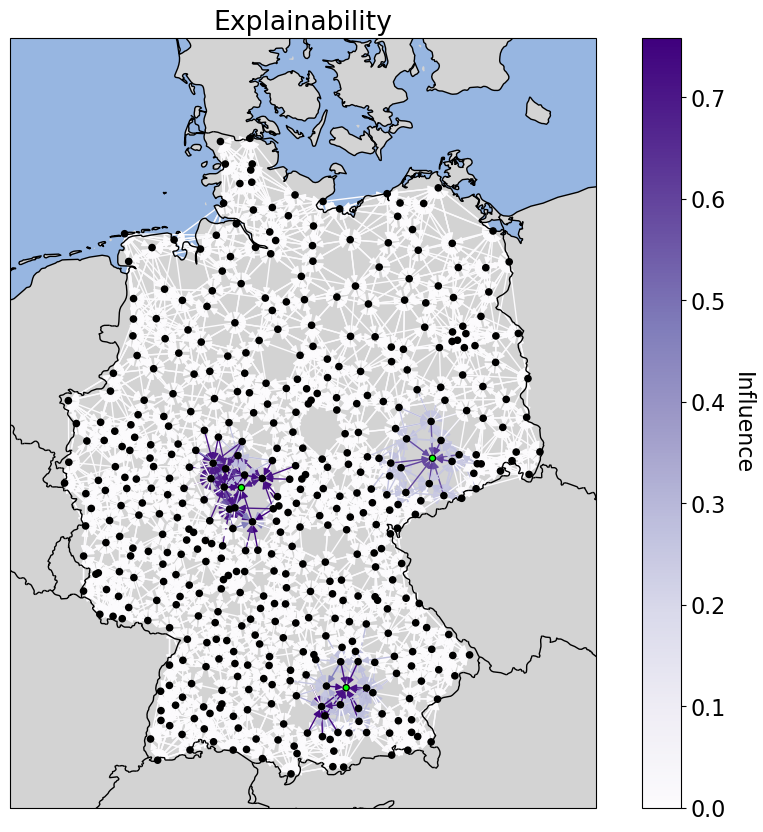

In [70]:
helpers.visualize_explanation(subgraph=sigma_explanation,
                              fullgraph=tmp,
                              stations=stations)